In [3]:
import os
import numpy as np
import pandas as pd
import json
from pathlib import Path
import glob
from tqdm import tqdm

import openslide
import tifffile
import math
import matplotlib.pyplot as plt
import time 
from PIL import Image
from sklearn.cluster import KMeans
from skimage.transform import resize
import cv2
import seaborn as sns
import xml.etree.ElementTree as ET
import joblib
import sys 
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
from hta.stats import HTA
from shapely.geometry import Point

root_code = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.insert(0, root_code)

from codebase.utils.eval_utils import get_protein_list
from codebase.utils.constants import *

In [4]:
# Parameters
submission_id='jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature' # '04ffsl0n_dgm4h_5GP+ASP_selected_snr_nature'
imc_pred_path_papermill='/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MODIGOS.npy'
ct_label_method='rf'  #  'ct_threshold' #'rf' #'prot_quantile-85'
cell_types='tumor_CD8' # '' 'tumor_CD8_CD4' 'tumor_CD8_CD4_CD20' 'all'
level=4

In [5]:
project_path = Path('/raid/sonali/project_mvs/')

# for random forest cell classifier
f_rf = project_path.joinpath('downstream_tasks/cell_typing/rf/split3/', cell_types, 'rf-cell_type-selected_snr_nature-raw_clip99_arc_otsu3_std_minmax_split3-r5-ntrees100-maxdepth30-ct_merged.joblib')
if cell_types == 'tumor_CD8':
    rf_cell_types = ['tumor', 'Tcells.CD8', 'other']
elif cell_types == 'tumor_CD8_CD4':
    rf_cell_types = ['tumor', 'Tcells.CD8', 'Tcells.CD4', 'other']
elif cell_types == 'tumor_CD8_CD4_CD20':
    rf_cell_types = ['tumor', 'Tcells.CD8', 'Tcells.CD4', 'Bcells', 'other']
elif cell_types == 'all':
    rf_cell_types = ['myeloid', 'Tcells.CD8', 'Bcells', 'tumor', 'vessels', 'Tcells.CD4', 'other']
rf_cell_types = sorted(rf_cell_types)
rf_cell_types

['Tcells.CD8', 'other', 'tumor']

In [6]:
# ---------------------------------------------# 
# Class for cell-typing on a whole-slide-level # 
# ---------------------------------------------# 

class wsi_celltyping: 
    def __init__(self, ct_label_method, radius):
        self.ct_label_method = ct_label_method
        self.radius = radius
        
    def get_wsi_celltyping(self, centroids_wsi, wsi_multiplex):

        if 'prot_quantile' in self.ct_label_method:
            fname = 'agg_masked_data-raw_clip99_arc_otsu3_std_minmax_split3-r5-train_quantiles'
            cohort_quantiles = pd.read_csv(project_path.joinpath('data/tupro/imc_updated/'+fname+'.tsv'), sep='\t', index_col=[0])
            quantile= int(self.ct_label_method.split('-')[-1])
        elif self.ct_label_method == 'rf':
            rf_object = joblib.load(f_rf)
            rf_cts = rf_cell_types 

        # --- wsi pixels to cell counts ---
        x_max, y_max, n_channels = wsi_multiplex.shape
        ct_labels = []

        # iterate over all identified nuclei coordinates
        for i, centroid in tqdm(enumerate(centroids_wsi), total=len(centroids_wsi), desc="Processing", unit="item"):
            x0 = centroid[0]
            y0 = centroid[1]

            # average protein expression within the circle
            protein_sum = np.zeros((1,n_channels))
            n_pixels = 0
            for x in range(abs(x0-self.radius),(x0+self.radius)):
                for y in range(abs(y0-self.radius),(y0+self.radius)):
                    if (((x-x0)**2 + (y-y0)**2) <= self.radius**2) and (x<x_max and y<y_max) and (x>0 and y >0):
                        protein_sum = protein_sum + wsi_multiplex[x,y,:]
                        n_pixels = n_pixels + 1
            if n_pixels == 0:
                ct_labels.append(np.nan)
            else:
                protein_mean = protein_sum/n_pixels
                # get cell-type label
                if self.ct_label_method == 'ct_threshold':
                    ct_label = self.get_ct_label_threshold(protein_list, protein_mean)        
                elif 'prot_quantile' in self.ct_label_method:
                    ct_label = self.get_ct_label_quantile(cohort_quantiles, protein_list, protein_mean, q=quantile)
                else:
                    assert n_channels==11, 'RF prediction atm is possible only if the full multiplex is predicted!'
                    ct_label = self.get_ct_label_rf(rf_object, rf_cts, protein_mean)
                ct_labels.append(ct_label)

        ct_labels = np.array(ct_labels)
        print(len(ct_labels), len(centroids_wsi))    
        return ct_labels

        
    def get_ct_label_quantile(self, cohort_quantiles, protein_list, protein_mean, q=75):
        ''' Get cell-type label (Tcells.CD8, tumor, other) based on cohort quantiles
        cohort quantiles: dataframe with train-set cohort quantiles (rows) per protein (columns)
        protein_list: names of proteins correspodning to columns of protein_sum
        protein_mean: average protein expression of the pseudo-cell
        q: quantile to use
        '''
        tumor_proteins = ['MelanA', 'gp100', 'S100', 'SOX9', 'SOX10']
        tumor_proteins = [x for x in tumor_proteins if x in protein_list]

        if protein_mean[:,protein_list.index('CD8a')] >= cohort_quantiles.loc['q0.'+str(q),'CD8a']:
            ct_label = 'Tcells.CD8'
        elif protein_mean[:,protein_list.index('CD3')] >= cohort_quantiles.loc['q0.'+str(q),'CD3']:
            ct_label = 'Tcells.CD3'
        elif np.sum(protein_mean[:,[protein_list.index(x) for x in tumor_proteins]] >= cohort_quantiles.loc['q0.'+str(q),tumor_proteins].values) > 0:
            ct_label = 'tumor'
        else:
            ct_label = 'other'
        return ct_label


    def get_ct_label_threshold(self, protein_list, protein_mean):
        ''' Get cell-type label (Tcells.CD8, tumor, other) based on predefined thresholds (125 among cells with the given cell-type label in train set)
        protein_list: names of proteins corresponding to columns of protein_sum
        protein_mean: average protein expression of the pseudo-cell
        '''
        tumor_proteins = ['MelanA', 'gp100', 'S100', 'SOX9', 'SOX10']
        tumor_proteins = [x for x in tumor_proteins if x in protein_list]
        tumor_thresholds = dict({'MelanA': 0.09, 'gp100': 0.06, 'S100': 0.04, 'SOX9': 0.02, 'SOX10': 0.1})
        tumor_thresholds = [tumor_thresholds[x] for x in tumor_proteins]

        if protein_mean[:,protein_list.index('CD8a')] >= 0.26:
            ct_label = 'Tcells.CD8'
        elif np.sum(protein_mean[:,[protein_list.index(x) for x in tumor_proteins]] >= tumor_thresholds)>0:
            ct_label = 'tumor'
        else:
            ct_label = 'other'
        return ct_label


    def get_ct_label_rf(self, rf_object, rf_cts, protein_mean):
        ''' Get cell-type label (Tcells.CD8, tumor, other) based on predefined thresholds (125 among cells with the given cell-type label in train set)
        rf_object: object with trained RF
        rf_cts: cell-type labels that RF was trained on / can predict
        protein_mean: average protein expression of the pseudo-cell
        '''
        raw_result = np.zeros((protein_mean.shape[0], len(rf_cts)))
        for i in range(len(rf_object.estimators_)):
            raw_result += rf_object.estimators_[i].predict(protein_mean)
        ct_label = rf_cts[np.argmax(raw_result)]
        ct_label = 'other' if ct_label not in ['Tcells.CD8', 'tumor', 'Tcells.CD3'] else ct_label
        return ct_label
    

In [7]:
# ----- Functions for annotation masks -----
def map_colors(image, colors):
    kmeans = KMeans(n_clusters=len(pre_defined_colors), random_state=0)
    kmeans.fit(colors)
    kmeans.cluster_centers_ = colors
    
    pixels = image.reshape(-1, 3)
    cluster_assignment = kmeans.predict(pixels.astype('double'))    
    pixel_labels = list(map(lambda x: colors[x], cluster_assignment))
    mapped_image = np.array(pixel_labels).reshape(image.shape).astype(np.uint8)

    return mapped_image


def get_hovernet_centroids(f_hovernet_sample, level):  
    # load h&e cell centers from hovernet output  
    df_hovernet_simple = pd.read_csv(
        f_hovernet_sample,
        usecols=['centroid_x', 'centroid_y']
    )

    centroids_wsi = df_hovernet_simple[['centroid_x', 'centroid_y']].values.tolist()
    print(len(centroids_wsi), centroids_wsi[0])

    # hovernet cell centriods and radius for level 
    centroids_wsi_level = (np.array(centroids_wsi)//(2**(level))).astype(int)
    print(centroids_wsi[0])
    return centroids_wsi_level


def get_annotation_masks(annots_path):
    # loading annotation masks: tumor and stroma within tumor compartment
    # reading using tifffile 
    img_annots = tifffile.imread(annots_path, key=0)
    print(wsi_pred.shape, img_annots.shape)

    # downsampling annotations as otherwise color mapping is slow  
    img_annots = cv2.resize(img_annots, (0,0), fx=0.25, fy=0.25) 
    print(img_annots.shape)

    # map colors correctly to annotations 
    img_annots = map_colors(img_annots, pre_defined_colors)
    print(img_annots.shape)

    colors, counts = np.unique(img_annots.reshape(-1, img_annots.shape[-1]), axis=0, return_counts=True)
    print('Unique colors and counts in annotated image: ', len(colors))#, colors, counts)
    assert len(colors)<=6, "more than 6 colors/annotations found in the image"

    # get tumor and stroma mask 
    mask_tumor = (np.all(img_annots == [255, 0, 0], axis=-1)).astype(np.uint8)
    mask_stroma = (np.all(img_annots == [0, 128, 0], axis=-1)).astype(np.uint8)
    mask_positive_lymphocytes = (np.all(img_annots == [255, 0, 255], axis=-1)).astype(np.uint8)
    mask_stroma = cv2.bitwise_or(mask_stroma, mask_positive_lymphocytes)
    print('masks: ', mask_tumor.shape, mask_stroma.shape)

    # make sure shape matches of annotations and wsi_pred 
    height, width = wsi_pred.shape[:2]
    mask_tumor = cv2.resize(mask_tumor, (width, height))
    mask_stroma = cv2.resize(mask_stroma, (width, height))

    print('masks: ', mask_tumor.shape, mask_stroma.shape)
    return mask_tumor, mask_stroma


def get_cellcount_in_mask(mask, centroids_CD8):
    mask_values_annots = mask[centroids_CD8[:, 1], centroids_CD8[:, 0]]
    coordinates_within_annots = centroids_CD8[mask_values_annots != 0]
    return len(coordinates_within_annots)


steps
1. get samples with predictions  
2. pixel to cell based wsi
    load hovernet coordinates 
    define radius 
    avg expression in radius 
3. count of cells in tumor and stroma region
4. area estimation and density calculation -- store in df for each sample 
5. get GT: label, area estimation, density calculation  


In [8]:
# --- settings and paths --- #
# experiment related
job_args = json.load(open(Path(project_path).joinpath('results',submission_id,'args.txt')))
cv_split = job_args['cv_split']
CV_SPLIT_ROIS_PATH = Path(project_path).joinpath(CV_SPLIT_ROIS_PATH)
cv = json.load(open(CV_SPLIT_ROIS_PATH))[cv_split] # train/test/valid rois for cv_split
protein_list = get_protein_list(job_args['protein_set'])  

# wsi related
resolution_he = 0.23 # um/px  wsi.properties['openslide.mpp-y']

# region annotations from Bernard for HE images
annots_path = Path(project_path).joinpath('downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/classifier_mask') # tif images
color_code = {(255, 255, 255): "Whitespace", # white
(255, 255, 0): "Positive Lymphocytes", # yellow   
(0, 0, 255): "Stroma", # blue
(255, 0, 0): "Tumor", # red           
(0, 0, 0): "others" # pigment etc 
         }
pre_defined_colors = [list(t) for t in list(color_code.keys())]
pre_defined_colors = np.array(pre_defined_colors).astype('double')

region_annots_path =  Path(project_path).joinpath('downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/240410AllAnnotations') # tumor and invasive margin annotations


# meta data for immune phenotyp tupro labels 
meta_path = Path(project_path).joinpath('meta/tupro/melanoma-merged_clinical_data-v8.tsv')

# pseudo cell related 
hovernet_path = Path(project_path).joinpath('downstream_tasks/immune_phenotyping/tupro/hovernet_output')
radius = 5 # um of a cell

# ground truth CD8 labels and desities (from Marta)
path_gt = Path(project_path).joinpath('downstream_tasks/immune_phenotyping/tupro/CD8_quantification/20220209_TuProcohort_CD8.xlsx')


In [9]:
# todo fix the function below and include input type for each argument 
def get_annotation_mask_HE(annot_path, pre_defined_colors, downsample):

    """
    For the input "annot_path", loads the tif file with region annotations at desired level "level_annots"
    Uses k-means to fix the annotation by mapping to nearest color from the pre_defined_colors. 
    Returns annotation image at the desired level and the fixed colors.
    """
         
    wsi_annots = openslide.OpenSlide(annot_path) # tif file 

    print(wsi_annots.level_dimensions)
    print(wsi_annots.level_downsamples)

    level = wsi_annots.get_best_level_for_downsample(downsample)
    print('level: ', level)
    print(wsi_annots.level_dimensions[level])

    img_annots = wsi_annots.read_region((0, 0), level, (wsi_annots.level_dimensions[level]))
    img_annots = np.array(img_annots.convert('RGB')).astype(np.uint8)

    print(img_annots.shape)

    # map colors correctly to annotations 
    img_annots = map_colors(img_annots, pre_defined_colors)

    colors, counts = np.unique(img_annots.reshape(-1, img_annots.shape[-1]), axis=0, return_counts=True)
    print('Unique colors and counts in annotated image: ', len(colors))#, colors, counts)
    assert len(colors)<=6, "more than 6 colors/annotations found in the image"

    print(colors, counts)

    return img_annots


def get_region_masks(img_annots, f_regions, downsample_factor=16, coutour_thickness=-1, plot=True): 

    mask_annotated = np.zeros((img_annots.shape), np.uint8)
    img_annots_tumor = np.zeros((img_annots.shape), np.uint8)
    img_annots_IM = np.zeros((img_annots.shape), np.uint8)

    tree = ET.parse(f_regions)
    Annotation = tree.findall('Annotation')
    # labels: TumorBorder is all of tumor; CoreTumor is TumorBorder minus 500um; InvasiveMargin is approx strip of 1mm from CoreTumor
    labels_dict = {"CoreTumor":(255,0,0), "InvasiveMargin":(0,255,0)}#, "TumorBorder":(0,0,255)}

    print(Annotation)

    for j in range(len(Annotation)):
        label = Annotation[j].get('Name')
        print('label: ', label)

        mask_inclusion = np.zeros((mask_annotated.shape), np.uint8)
        mask_exclusion = np.zeros((mask_annotated.shape), np.uint8)

        if label in labels_dict.keys(): 
            n_regions = len(Annotation[j].findall('Regions/Region'))

            for i in range(n_regions): 
                region = Annotation[j].findall('Regions/Region')[i]
                exclusion = region.get('NegativeROA')
                vertices = region.findall('Vertices/V')

                # get vertices for the region
                loc_temp = []
                for counter, x in enumerate(vertices):
                    loc_X = int(float(x.attrib['X']))
                    loc_Y = int(float(x.attrib['Y']))
                    loc_temp.append([loc_X, loc_Y])
                loc_temp = np.asarray(loc_temp)
                loc_temp = loc_temp / downsample_factor # just to plot the coordinates on a downsampled image
                loc_temp = loc_temp.astype(int)

                if int(exclusion)==1: 
                    mask_exclusion = cv2.drawContours(mask_exclusion, [loc_temp], 0, labels_dict[label], coutour_thickness)

                elif int(exclusion)!=1: 
                    mask_inclusion = cv2.drawContours(mask_inclusion, [loc_temp], 0, labels_dict[label], coutour_thickness)               

            # for label merge inclusion exclusion masks 
            mask_label = mask_inclusion
            mask_label[np.where(mask_inclusion==mask_exclusion)]=0
            mask_annotated = np.maximum(mask_annotated, mask_label)

            if label == 'CoreTumor': 
                mask_label[mask_label!=0] = 255
                img_annots_tumor = cv2.bitwise_and(img_annots, img_annots, mask=cv2.cvtColor(mask_label, cv2.COLOR_BGR2GRAY))
            elif label == 'InvasiveMargin': 
                mask_label[mask_label!=0] = 255
                img_annots_IM = cv2.bitwise_and(img_annots, img_annots, mask=cv2.cvtColor(mask_label, cv2.COLOR_BGR2GRAY))

    overlay = cv2.addWeighted(img_annots,0.3,mask_annotated,0.7,0)

    if plot: 
        # plotting img_annots_fixed and img_annots_ side by side 
        fig, ax = plt.subplots(1,5, figsize=(20,20))
        ax[0].imshow(img_annots/255)
        ax[1].imshow(mask_annotated/255)
        ax[2].imshow(overlay/255)
        ax[3].imshow(img_annots_tumor/255)
        ax[4].imshow(img_annots_IM/255)

        plt.show()

    return img_annots_tumor, img_annots_IM

In [10]:
save_path_processed_annotations = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/tumor_IM_annotations'
os.makedirs(save_path_processed_annotations, exist_ok=True)

for tif_annotation_path in glob.glob(str(annots_path) + '/' + '*.tif'):
    sample = tif_annotation_path.split('/')[-1].split('-')[0].split('_')[0]
    region_annotation_path = glob.glob(str(region_annots_path) + '/' + sample + '*.annotations')[0]

    if not os.path.exists(save_path_processed_annotations + '/' + sample + '_annotated_tumor_IM.npz'):
        print(f"sample: {sample}")
        print(f"tif annotation path: {tif_annotation_path}")
        print(f"region annotation path: {region_annotation_path}")

        img_annotation = get_annotation_mask_HE(tif_annotation_path, pre_defined_colors, downsample=16)
        print(f"img_annotation: {img_annotation.shape}")

        # resizing as tif annotated image is saved at resolutuon of 0.3um/px and HE is at resolution 0.23um/px -- so resizing to match the HE image
        img_annotation = cv2.resize(img_annotation, (0,0), fx=(0.3/0.23), fy=((0.3/0.23)))
        print(f"img_annotation: {img_annotation.shape}")

        img_annots_tumor, img_annots_IM = get_region_masks(img_annotation, region_annotation_path, downsample_factor=16, coutour_thickness=-1)
        print(f"img_annots_tumor: {img_annots_tumor.shape}, img_annots_IM: {img_annots_IM.shape}")

        # saving the annotated images
        np.savez(save_path_processed_annotations + '/' + sample + '_annotated_tumor_IM.npz', img_annots_tumor=img_annots_tumor, img_annots_IM=img_annots_IM)
    else: 
        print(f"sample: {sample} already exists")




sample: MEFYFAK already exists
sample: MIMANAR already exists
sample: MAJEFEV already exists
sample: MODALEG already exists
sample: MATIWAQ already exists
sample: MADUFEM already exists
sample: MOCEGIB already exists
sample: MIBUBIR already exists
sample: MIDOJYB already exists
sample: MELIPIT already exists
sample: MUDEFAW already exists
sample: MUFYDUM already exists
sample: MIFOGIL already exists
sample: MACEGEJ already exists
sample: MUBIBIT already exists
sample: MENYTEK already exists
sample: MUKAGOX already exists
sample: MIDEKOG already exists
sample: MOROPEX already exists
sample: MYBYFUW already exists
sample: MADIBUG already exists
sample: MIGEDEK already exists
sample: MEHEHUM already exists
sample: MUBYJOF already exists
sample: MIJUCYK already exists
sample: MEWORAT already exists
sample: MILABYL already exists
sample: MUFOFOP already exists
sample: MEKAKYD already exists
sample: MALYLEJ already exists
sample: MIMUVYF already exists
sample: MODOHOX already exists
sample: 

In [11]:
samples_splits = json.load(open(project_path.joinpath('meta/tupro/mvs-cv_split-samples-v6.json')))
hovernet_all_samples = [x.split('/')[-1].split('-')[0] for x in glob.glob(str(hovernet_path) + '/*gz')]
hovernet_all_samples = list(np.unique(hovernet_all_samples))

meta = pd.read_csv(meta_path, sep='\t', index_col=[0])[['tupro_id', 'cd8_phenotype_revised', 'pathology_immune_diagnosis']]
meta


,tupro_id,cd8_phenotype_revised,pathology_immune_diagnosis
0,MR9T5,unknown,inflamed
1,MMGMO,unknown,immune excluded
2,MY5BB,unknown,immune excluded
3,M8BO8,unknown,inflamed (exhausted)
4,M3UI6,unknown,inflamed
...,...,...,...
129,MUBIBIT,inflamed,inflamed with signs of exhaustion
130,MYHAJIS,immune excluded,immune excluded
131,MACOLUD,immune excluded,immune excluded
132,MELUKUZ,immune desert,immune desert with TLSs


In [14]:
imc_pred_basepath = Path(project_path).joinpath('results',submission_id, 'all-tupro_wsis', 'epochlast',  'level_'+str(level))
imc_pred_paths = glob.glob(str(imc_pred_basepath) + '/*npy')
print(len(imc_pred_paths), imc_pred_paths[0])


110 /raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MODIGOS.npy


In [15]:
# functions for getting cell count densities etc

def get_celltype_centroids(celltype, ct_labels, centroids_wsi_level):
    indices = np.where(ct_labels==celltype)
    if len(indices[0])!=0: 
        centroids = centroids_wsi_level[indices]
    else: 
        print(f"No {celltype} predicted")
        centroids = []
    return centroids

def get_stroma_tumor_mask(img_annots_compartment): 
    mask_tumor = (np.all(img_annots_compartment == [255, 0, 0], axis=-1)).astype(np.uint8)
    mask_stroma = (np.all(img_annots_compartment == [0, 0, 255], axis=-1)).astype(np.uint8)
    mask_positive_lymphocytes = (np.all(img_annots_compartment == [255, 255, 0], axis=-1)).astype(np.uint8)
    mask_stroma = cv2.bitwise_or(mask_stroma, mask_positive_lymphocytes)
    return mask_tumor, mask_stroma

def get_cellcount_area_density(mask_tumor, mask_stroma, centroids_celltype, resolution_level):
    iCD_count, sCD_count = 0, 0
    if len(centroids_celltype)!=0: 
        iCD_count = get_cellcount_in_mask(mask_tumor, centroids_celltype)
        sCD_count = get_cellcount_in_mask(mask_stroma, centroids_celltype)

    # annotated area calculation 
    n_tumor_pixels = np.count_nonzero(mask_tumor)
    n_stroma_pixels = np.count_nonzero(mask_stroma)

    iCD_area = (n_tumor_pixels*(resolution_level**2)) # in um2 
    sCD_area = (n_stroma_pixels*(resolution_level**2)) # in um2

    # density calculation 
    iCD_density = 0 if iCD_area==0 else iCD_count/iCD_area
    sCD_density = 0 if sCD_area==0 else sCD_count/sCD_area
    # iCD_density = iCD_count/iCD_area
    # sCD_density = sCD_count/sCD_area
    return iCD_count, sCD_count, iCD_area, sCD_area, iCD_density, sCD_density

In [16]:
imc_pred_paths[0]

'/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MODIGOS.npy'

In [17]:
# save_path_analysis = os.path.join('/raid/sonali/project_mvs/results', submission_id, 'all-tupro_wsis', 'epochlast',  'immune_phenotyping', 'TuPro_best_annots', ct_label_method + '_' + cell_types)
save_path_analysis = os.path.join('/raid/sonali/project_mvs/results', submission_id, 'all-tupro_wsis', 'epochlast',  'immune_phenotyping', ct_label_method + '_' + cell_types)

os.makedirs(save_path_analysis, exist_ok=True)
print(save_path_analysis)

csv_save_path = os.path.join(save_path_analysis, 'immune_phenotype-pred-' + ct_label_method + '_' + cell_types + '.csv')
csv_save_path

/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/immune_phenotyping/rf_tumor_CD8


'/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/immune_phenotyping/rf_tumor_CD8/immune_phenotype-pred-rf_tumor_CD8.csv'

In [18]:

resolution_level = resolution_he * (2**level)
radius_level = round(radius/resolution_level)
celltyping_obj = wsi_celltyping(ct_label_method, radius_level)


df_columns = ['Case_ID', 'iCD8_density_TC', 'sCD8_density_TC', 'iCD8_area_TC', 'sCD8_area_TC', 'iCD8_count_TC', 'sCD8_count_TC', 
                'iCD8_density_IM', 'sCD8_density_IM', 'iCD8_area_IM', 'sCD8_area_IM', 'iCD8_count_IM', 'sCD8_count_IM',
                'iCD3_density_TC', 'sCD3_density_TC', 'iCD3_area_TC', 'sCD3_area_TC', 'iCD3_count_TC', 'sCD3_count_TC',
                'iCD3_density_IM', 'sCD3_density_IM', 'iCD3_area_IM', 'sCD3_area_IM', 'iCD3_count_IM', 'sCD3_count_IM',
                'data split']
# df_data = []

if os.path.exists(csv_save_path):
    df_pred = pd.read_csv(csv_save_path)
else:
    df_pred = pd.DataFrame(columns=df_columns)  # Create an empty df
    df_pred.to_csv(csv_save_path, index=False)

for imc_pred_path in imc_pred_paths: 

    print(imc_pred_path)
    sample = imc_pred_path.split('/')[-1].split('.')[0]

    if sample in df_pred['Case_ID'].values:
        print(f"sample: {sample} already processed")
        continue 

    if imc_pred_path_papermill == imc_pred_path:
    # if True: 
        # get the split of the sample
        sample_split = next((k for k, v in cv.items() if any(sample in item for item in v)), None)
        if not sample_split: 
            sample_split = 'test'
        
        print('sample_split: ', sample_split)
        # get GT immune phenotype
        sample_phenotype = meta.loc[meta['tupro_id']==sample, 'cd8_phenotype_revised']
        print('GT immune phenotype: ', sample_phenotype)

        # load predicted wsi
        wsi_pred = np.load(imc_pred_path)
        print('wsi_pred: ', wsi_pred.shape)

        # get hovernet cell centroids
        f_hovernet_sample = glob.glob(str(hovernet_path) + '/' + sample + '*.gz')[0]
        centroids_wsi_level = get_hovernet_centroids(f_hovernet_sample, level)
        print(radius, radius_level)

        # --- wsi pixels to cell counts ---
        ct_labels = celltyping_obj.get_wsi_celltyping(centroids_wsi_level, wsi_pred)
        labels, counts = np.unique(ct_labels, axis=0, return_counts=True)
        print(labels, counts)

        # get celltype centroids
        centroids_CD8 = get_celltype_centroids(celltype='Tcells.CD8', ct_labels=ct_labels, centroids_wsi_level=centroids_wsi_level)
        centroids_CD3 = get_celltype_centroids(celltype='Tcells.CD3', ct_labels=ct_labels, centroids_wsi_level=centroids_wsi_level)
        centroids_tumor = get_celltype_centroids(celltype='tumor', ct_labels=ct_labels, centroids_wsi_level=centroids_wsi_level)

        print('centroids CD8: ', len(centroids_CD8))
        print('centroids CD3: ', len(centroids_CD3))
        print('centroids tumor: ', len(centroids_tumor))

        # loading annotation masks: tumor and stroma within tumor compartment

        annotation_path_sample = save_path_processed_annotations + '/' + sample + '_annotated_tumor_IM.npz'
        if not os.path.exists(save_path_processed_annotations + '/' + sample + '_annotated_tumor_IM.npz'):
            print(f"sample: {sample} does not have annotations")
            continue

        img_annots = np.load(annotation_path_sample)
            
        # tumor and stroma mask for tumor compartment and invasive margin
        mask_TC_tumor, mask_TC_stroma = get_stroma_tumor_mask(img_annots['img_annots_tumor']) # for tumor compartment
        mask_IM_tumor, mask_IM_stroma = get_stroma_tumor_mask(img_annots['img_annots_IM']) # for invasive margin

        print('mask TC stroma and tumor ', mask_TC_stroma.shape, mask_TC_tumor.shape)
        print('mask IM stroma and tumor: ', mask_IM_stroma.shape, mask_IM_tumor.shape)

        # getting cell count in regions 
        # for TC
        iCD8_count_TC, sCD8_count_TC, iCD8_area_TC, sCD8_area_TC, iCD8_density_TC, sCD8_density_TC = get_cellcount_area_density(mask_TC_tumor, mask_TC_stroma, centroids_CD8, resolution_level)
        iCD3_count_TC, sCD3_count_TC, iCD3_area_TC, sCD3_area_TC, iCD3_density_TC, sCD3_density_TC = get_cellcount_area_density(mask_TC_tumor, mask_TC_stroma, centroids_CD3, resolution_level)

        # for IM
        iCD8_count_IM, sCD8_count_IM, iCD8_area_IM, sCD8_area_IM, iCD8_density_IM, sCD8_density_IM = get_cellcount_area_density(mask_IM_tumor, mask_IM_stroma, centroids_CD8, resolution_level)
        iCD3_count_IM, sCD3_count_IM, iCD3_area_IM, sCD3_area_IM, iCD3_density_IM, sCD3_density_IM = get_cellcount_area_density(mask_IM_tumor, mask_IM_stroma, centroids_CD3, resolution_level)

        print('CD8 TC: ', iCD8_count_TC, sCD8_count_TC, iCD8_area_TC, sCD8_area_TC, iCD8_density_TC, sCD8_density_TC)
        print('CD8 IM: ', iCD8_count_IM, sCD8_count_IM, iCD8_area_IM, sCD8_area_IM, iCD8_density_IM, sCD8_density_IM)
        print('CD3 TC: ', iCD3_count_TC, sCD3_count_TC, iCD3_area_TC, sCD3_area_TC, iCD3_density_TC, sCD3_density_TC)
        print('CD3 IM: ', iCD3_count_IM, sCD3_count_IM, iCD3_area_IM, sCD3_area_IM, iCD3_density_IM, sCD3_density_IM)

        new_row = [sample, iCD8_density_TC, sCD8_density_TC, iCD8_area_TC, sCD8_area_TC, iCD8_count_TC, sCD8_count_TC, 
                        iCD8_density_IM, sCD8_density_IM, iCD8_area_IM, sCD8_area_IM, iCD8_count_IM, sCD8_count_IM, 
                        iCD3_density_TC, sCD3_density_TC, iCD3_area_TC, sCD3_area_TC, iCD3_count_TC, sCD3_count_TC,
                        iCD3_density_IM, sCD3_density_IM, iCD3_area_IM, sCD3_area_IM, iCD3_count_IM, sCD3_count_IM, 
                        sample_split]
        
        sample_row_df = pd.DataFrame([new_row], columns=df_columns)
        sample_row_df.to_csv(csv_save_path, mode='a', header=False)

        # save coordinates visualisation
        np.savez(os.path.join(save_path_analysis, sample + '-cell_coordinated.npz'), centroids_CD8=centroids_CD8, centroids_CD3=centroids_CD3, centroids_tumor=centroids_tumor, density_analysis=new_row)

    

/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MODIGOS.npy
sample: MODIGOS already processed
/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MOJYMOC.npy
/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MOROPEX.npy
sample: MOROPEX already processed
/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MAHACEB.npy
sample: MAHACEB already processed
/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MEMIGOG.npy
sample: MEMIGOG already processed
/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/MEPELEX.npy
sample: MEPELEX already processed
/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/lev

In [19]:
new_row


NameError: name 'new_row' is not defined

### Getting heterogenity score

In [20]:
meta

,tupro_id,cd8_phenotype_revised,pathology_immune_diagnosis
0,MR9T5,unknown,inflamed
1,MMGMO,unknown,immune excluded
2,MY5BB,unknown,immune excluded
3,M8BO8,unknown,inflamed (exhausted)
4,M3UI6,unknown,inflamed
...,...,...,...
129,MUBIBIT,inflamed,inflamed with signs of exhaustion
130,MYHAJIS,immune excluded,immune excluded
131,MACOLUD,immune excluded,immune excluded
132,MELUKUZ,immune desert,immune desert with TLSs


In [ ]:
hta_save_path = os.path.join(save_path_analysis, 'hta_Samples.csv')
hta_cols = ['sample', 'immune_subtype', 'HTA', 'HTA_pval']


if os.path.exists(hta_save_path):
    df_hta = pd.read_csv(hta_save_path)
else:
    df_hta = pd.DataFrame(columns=hta_cols)  # Create an empty df
    df_hta.to_csv(hta_save_path, index=False)

region_size = 100  

for coords_path in glob.glob(save_path_analysis + '/*-cell_coordinated.npz'):
    sample = coords_path.split('/')[-1].split('-')[0]

    if sample in df_hta['sample'].values:
        print(f"sample: {sample} already processed")
        continue 

    # get immue subtype using meta for sample
    immune_subtype = meta.loc[meta['tupro_id']==sample, 'cd8_phenotype_revised'].values[0]

    print(immune_subtype, sample)
    coords = np.load(coords_path)
    coords_tumor = coords['centroids_tumor']
    coords_CD8 = coords['centroids_CD8']

    # get max x and y coordinates for both tumor and CD8 cells
    max_x = max(np.max(coords_tumor[:,0]), np.max(coords_CD8[:,0]))
    max_y = max(np.max(coords_tumor[:,1]), np.max(coords_CD8[:,1]))

    # get a new array with the same shape as the image with two channels for tumor and CD8 cells
    # in each channel, if a pixel is occupied by a cell, the value is 1, otherwise 0
    image = np.zeros((max_x+1, max_y+1, 2))
    for i in range(coords_tumor.shape[0]):
        x, y = coords_tumor[i]
        image[x, y, 0] = 1
    for i in range(coords_CD8.shape[0]):
        x, y = coords_CD8[i]
        image[x, y, 1] = 1

    # image as int 
    image = image.astype(int)
    print(image.shape)

    # resize
    factor = 10
    new_size = (image.shape[1] // factor, image.shape[0] // factor)  # (width, height)
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    print(image.shape)

    hta = HTA(image, region_size)
    hta_stat, hta_pval = hta.calc()
    print('HTA {:.2f},  p-val: {:.2e}'.format(hta_stat, hta_pval))

    sample_hta_df = pd.DataFrame([[sample, immune_subtype, round(hta_stat, 3), round(hta_pval, 5)]], columns=hta_cols)
    sample_hta_df.to_csv(hta_save_path, mode='a', header=False)

sample: MYBYFUW already processed
sample: MOMUSIG already processed
sample: MIBUBIR already processed
sample: MELIPIT already processed
sample: MECYGYR already processed
sample: MUBIBIT already processed
sample: MIFOGIL already processed
sample: MYBYHER already processed
sample: MABABAB already processed
sample: MIMUVYF already processed
sample: MODAJOH already processed
sample: MAHOBAM already processed
sample: MISYPUP already processed
sample: MACEGEJ already processed
sample: MIBIBUJ already processed
sample: MAHEFOG already processed
sample: MATIWAQ already processed
sample: MADAJEJ already processed
sample: MODOHOX already processed
sample: MEWORAT already processed
sample: MADIBUG already processed
sample: MOTAMUH already processed
sample: MUFOFOP already processed
sample: MEKOBAB already processed
sample: MODIGOS already processed
sample: MOBICUN already processed
sample: MOLOLYB already processed
sample: MELYPEB already processed
sample: MACYHYS already processed
sample: MOGYLI

In [18]:
## HTA for cells inside tumor compartment

hta_save_path = os.path.join(save_path_analysis, 'hta_Samples_tumor-center.csv')
hta_cols = ['sample', 'immune_subtype', 'HTA', 'HTA_pval']

if os.path.exists(hta_save_path):
    df_hta = pd.read_csv(hta_save_path)
else:
    df_hta = pd.DataFrame(columns=hta_cols)  # Create an empty df
    df_hta.to_csv(hta_save_path, index=False)

region_size = 100  

BH_annotations_path = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/tumor_IM_annotations'

for coords_path in glob.glob(save_path_analysis + '/*-cell_coordinated.npz'):

    sample = coords_path.split('/')[-1].split('-')[0]

    if sample in df_hta['sample'].values:
        print(f"sample: {sample} already processed")
        continue
     
    immune_subtype = meta.loc[meta['tupro_id']==sample, 'cd8_phenotype_revised'].values[0]

    print(immune_subtype, sample)

    coords = np.load(coords_path)
    coords_tumor = coords['centroids_tumor']
    coords_CD8 = coords['centroids_CD8']

    data = np.load(coords_path)
    print(data.files)

    # load region annotations to prune coordinates
    sample_annotation_path = BH_annotations_path + '/' + sample + '_annotated_tumor_IM.npz'
    TC_img = np.load(sample_annotation_path)['img_annots_tumor']

    # Get the non-zero pixel coordinates from the image
    non_zero_indices = np.transpose(np.nonzero(np.any(TC_img != [0, 0, 0], axis=-1)))
    print(len(non_zero_indices))

    # Get the centroids of the CD8+ cells inside tumor center
    center_points = [Point(center) for center in coords_CD8]
    non_zero_points = [point for point in center_points if TC_img[int(point.y), int(point.x)][0] != 0]
    coords_CD8 = [[int(point.x), int(point.y)] for point in non_zero_points]
    print(len(coords['centroids_CD8']), len(coords_CD8))

    # Get the centroids of the Tumor cells inside tumor center
    center_points = [Point(center) for center in coords_tumor]
    non_zero_points = [point for point in center_points if TC_img[int(point.y), int(point.x)][0] != 0]
    coords_tumor = [[int(point.x), int(point.y)] for point in non_zero_points]
    print(len(coords['centroids_tumor']), len(coords_tumor))

    coords_tumor = np.array(coords_tumor)
    coords_CD8 = np.array(coords_CD8)

    if len(coords_tumor) == 0 or len(coords_CD8) == 0:
        print('No cells in tumor center')
        sample_hta_df = pd.DataFrame([[sample, immune_subtype, 0, 0]], columns=hta_cols)
        sample_hta_df.to_csv(hta_save_path, mode='a', header=False)
        continue

    # get max x and y coordinates for both tumor and CD8 cells
    max_x = max(np.max(coords_tumor[:,0]), np.max(coords_CD8[:,0]))
    max_y = max(np.max(coords_tumor[:,1]), np.max(coords_CD8[:,1]))

    # get a new array with the same shape as the image with two channels for tumor and CD8 cells
    # in each channel, if a pixel is occupied by a cell, the value is 1, otherwise 0
    image = np.zeros((max_x+1, max_y+1, 2))
    for i in range(coords_tumor.shape[0]):
        x, y = coords_tumor[i]
        image[x, y, 0] = 1
    for i in range(coords_CD8.shape[0]):
        x, y = coords_CD8[i]
        image[x, y, 1] = 1

    # image as int 
    image = image.astype(int)
    print(image.shape)

    # resize
    factor = 10
    new_size = (image.shape[1] // factor, image.shape[0] // factor)  # (width, height)
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    print(image.shape)

    hta = HTA(image, region_size)
    hta_stat, hta_pval = hta.calc()
    print('HTA {:.2f},  p-val: {:.2e}'.format(hta_stat, hta_pval))

    sample_hta_df = pd.DataFrame([[sample, immune_subtype, round(hta_stat, 3), round(hta_pval, 5)]], columns=hta_cols)
    sample_hta_df.to_csv(hta_save_path, mode='a', header=False)



sample: MYBYFUW already processed
sample: MOMUSIG already processed
sample: MIBUBIR already processed
sample: MELIPIT already processed
sample: MECYGYR already processed
sample: MUBIBIT already processed
sample: MIFOGIL already processed
sample: MYBYHER already processed
sample: MABABAB already processed
sample: MIMUVYF already processed
sample: MODAJOH already processed
sample: MAHOBAM already processed
sample: MISYPUP already processed
sample: MACEGEJ already processed
sample: MIBIBUJ already processed
sample: MAHEFOG already processed
sample: MATIWAQ already processed
sample: MADAJEJ already processed
sample: MODOHOX already processed
sample: MEWORAT already processed
sample: MADIBUG already processed
sample: MOTAMUH already processed
sample: MUFOFOP already processed
sample: MEKOBAB already processed
sample: MODIGOS already processed
sample: MOBICUN already processed
sample: MOLOLYB already processed
sample: MELYPEB already processed
sample: MACYHYS already processed
sample: MOGYLI

In [ ]:
coords_tumor.shape, coords_CD8.shape

((46, 2), (0,))

In [22]:
# stratifying and plotting 
hta_save_path = os.path.join(save_path_analysis, 'hta_Samples.csv')
df_hta = pd.read_csv(hta_save_path)
df_hta


,sample,immune_subtype,HTA,HTA_pval
0,MYBYFUW,immune desert,0.455,0.00000
0,MOMUSIG,immune desert,0.566,0.33690
0,MIBUBIR,immune desert,0.366,0.17611
0,MELIPIT,immune excluded,0.334,0.03796
0,MECYGYR,immune excluded,0.376,0.00046
...,...,...,...,...
0,MODALEG,immune excluded,0.231,0.15753
0,MIDOBOL,inflamed,0.797,0.00000
0,MIMOHIS,immune desert,0.000,0.50000
0,MUBYJOF,immune excluded,0.243,0.17862


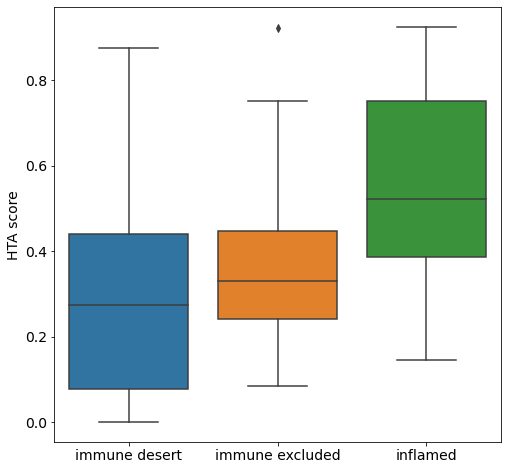

In [24]:
fig_single, ax_single = plt.subplots(figsize=(8, 8))
custom_order = ['immune desert', 'immune excluded', 'inflamed']
sns.boxplot(x='immune_subtype', y='HTA', data=df_hta, order=custom_order, ax=ax_single)
ax_single.set_title('')
ax_single.set_xlabel('')
ax_single.set_ylabel('HTA score', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


### Visualizing predicted cells on H&E 

In [ ]:
# save_path_cells = os.path.join('/raid/sonali/project_mvs/results', submission_id, 'all-tupro_wsis', 'epochlast',  'immune_phenotyping','TuPro_best_annots', ct_label_method)
# save_path_analysis = os.path.join('/raid/sonali/project_mvs/results', submission_id, 'all-tupro_wsis', 'epochlast',  'immune_phenotyping', ct_label_method + '_' + cell_types)

print(save_path_analysis) 
len(glob.glob(save_path_analysis + '/*cell_coordinated.npz'))


In [ ]:
# getting GT immune phenotypes for samples 
path_gt = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/CD8_quantification/20220209_TuProcohort_CD8.xlsx'
xl = pd.ExcelFile(path_gt)
df_gt = xl.parse("Tabelle1")
df_gt = df_gt[['Case_ID', 'Analysis_Region', 'Revised immune diagnosis', 'Density Tumor', 'Density Stroma total', 'Tumor Area (um²)',
  'Positive Lymphocytes Area (um²)', 'Stroma Area (um²)', 'Tumor:_AP_Positive_Cells', 'Stroma:_AP_Positive_Cells', 'Positive_Lymphocytes:_AP_Positive_Cells']]
df_gt['Total_Stroma:_AP_Positive_Cells'] = df_gt['Stroma:_AP_Positive_Cells'] + df_gt['Positive_Lymphocytes:_AP_Positive_Cells']
df_gt['Total Stromal area'] = df_gt['Stroma Area (um²)'] + df_gt['Positive Lymphocytes Area (um²)']
df_gt.drop(columns=['Stroma Area (um²)', 'Positive Lymphocytes Area (um²)', 'Stroma:_AP_Positive_Cells', 'Positive_Lymphocytes:_AP_Positive_Cells'], inplace=True)
df_gt = df_gt.drop(df_gt[df_gt['Analysis_Region'] == 'IM'].index)#.reset_index()
df_gt = df_gt.drop(df_gt[df_gt['Analysis_Region'] == 'Peritumoral'].index)#.reset_index()
df_gt.rename(columns={'Case_ID': 'tupro_id'}, inplace=True)
df_gt = pd.merge(df_gt, meta, on='tupro_id')[['tupro_id', 'cd8_phenotype_revised', 'pathology_immune_diagnosis']]
df_gt

In [ ]:
# plotting predicted CD8+ cells on HE and GT CD8+ T cells on IHC images
from shapely.geometry import Point

HE_basepath = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/HE_new_wsi'
BH_annotations_path = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/tumor_IM_annotations'
path_IHC_wsi = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/CD8_IHC'
path_IHC_cells = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/CD8_quantification/CD8_cells_coordinates'

samples_of_interest = ['MYGIFUD', 'MIDOBOL', 'MISYPUP', # inflamed
                       'MUGAHEK', 'MEWORAT', 'MOBICUN', 'MIDEKOG', 'MEFYFAK', 'MUBYJOF', # excluded 'MEJEFEV'
                       'MEKAKYD'] # desert 

plot_IHC = False
plot_Tumor_cells = True
figs_save_directory = '/raid/sonali/project_mvs/results/final_results/immune_phenotyping'  # Replace with your desired path

# for coordinates_file in glob.glob(save_path_cells + '/*cell_coordinated.npz'): 
for sample_of_interest in samples_of_interest: 
    print(sample_of_interest)
    print(save_path_analysis)
    print(glob.glob(save_path_analysis + '/*'))
    coordinates_file = glob.glob(save_path_analysis + '/' + sample_of_interest +  '*cell_coordinated.npz')[0]
    print(coordinates_file)

    sample = coordinates_file.split('/')[-1].split('-')[0]
    print(sample)
    data = np.load(coordinates_file)
    print(data.files)

    # --- getting phenotype for sample ---
    sample_phenotype = df_gt.loc[df_gt['tupro_id'] == sample][['cd8_phenotype_revised', 'pathology_immune_diagnosis']].values[0]#, 'Revised immune diagnosis']]
    print(sample_phenotype)

    # --- loading HE at desired level ---
    sample_HE_path = glob.glob(HE_basepath + '/*' + sample + '*.ndpi')[0]
    wsi = openslide.OpenSlide(sample_HE_path)
    he_img = wsi.read_region((0, 0), level, (wsi.level_dimensions[level]))
    he_img = np.array(he_img.convert('RGB')).astype(np.uint8)
    print(he_img.shape)

    # --- loading CD8 IHC ---
    if plot_IHC: 
        sample_IHC_path = glob.glob(path_IHC_wsi + '/*' + sample + '*.tif')[0]
        wsi = openslide.OpenSlide(sample_IHC_path)
        ihc_img = wsi.read_region((0, 0), level, (wsi.level_dimensions[level]))
        ihc_img = np.array(ihc_img.convert('RGB')).astype(np.uint8)
        print(ihc_img.shape)

        # --- loading IHC cell coordinates and plotting on CD8 IHC image ---
        sample_IHC_cells = glob.glob(path_IHC_cells + '/*' + sample + '*_tumor_center.csv')[0]
        df_ihc_cells = pd.read_csv(sample_IHC_cells)[['XMin', 'XMax', 'YMin', 'YMax', 'Classifier Label', 'AP Positive']]
        df_ihc_cells = df_ihc_cells[(df_ihc_cells['AP Positive'] == 1)].reset_index()
        df_ihc_cells[['XMin', 'XMax', 'YMin', 'YMax']] = df_ihc_cells[['XMin', 'XMax', 'YMin', 'YMax']].div(2**level).astype('int32')
        df_ihc_cells['XCenter'] = ((df_ihc_cells['XMin'] + df_ihc_cells['XMax']) / 2).astype(int)
        df_ihc_cells['YCenter'] = ((df_ihc_cells['YMin'] + df_ihc_cells['YMax']) / 2).astype(int)


        coords_IHC_cells = df_ihc_cells[['XCenter', 'YCenter']].to_numpy()
        print('CD8+ cells in ', len(coords_IHC_cells))

        ihc_img_centroids = ihc_img.copy()
        for coord in coords_IHC_cells: 
            ihc_img_centroids = cv2.circle(ihc_img_centroids, tuple(coord), 4, (255, 0, 0), 1) 

    # --- HE with TC boundary overlay ---
    region_annotation_path = glob.glob(str(region_annots_path) + '/' + sample_of_interest + '*.annotations')[0]
    img_annots_tumor, _ = get_region_masks(he_img, region_annotation_path, downsample_factor=2**level, coutour_thickness=10, plot=False)

    # gettting contour from TC mask 
    gray_image = cv2.cvtColor(img_annots_tumor, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(binary_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE) # Find contours

    # Draw the contours based on their hierarchy
    for i, contour in enumerate(contours):
        if hierarchy[0][i][3] == -1:# External boundary (no parent)
            cv2.drawContours(he_img, [contour], -1, (200,200,200), 10)  # Solid line for outer contours

    # --- drawing cell coordinates on he img ---
    # load annotations for the sample qnd overlay on HE
    sample_annotation_path = BH_annotations_path + '/' + sample + '_annotated_tumor_IM.npz'
    TC_img = np.load(sample_annotation_path)['img_annots_tumor']

    # Get the non-zero pixel coordinates from the image
    non_zero_indices = np.transpose(np.nonzero(np.any(TC_img != [0, 0, 0], axis=-1)))
    print(len(non_zero_indices))

    # Get the centroids of the CD8+ cells inside tumor center
    center_points = [Point(center) for center in data['centroids_CD8']]
    non_zero_points = [point for point in center_points if TC_img[int(point.y), int(point.x)][0] != 0]
    centroids_CD8_pruned = [[int(point.x), int(point.y)] for point in non_zero_points]
    print(len(data['centroids_CD8']), len(centroids_CD8_pruned))

    # Get the centroids of the Tumor cells inside tumor center
    center_points = [Point(center) for center in data['centroids_tumor']]
    non_zero_points = [point for point in center_points if TC_img[int(point.y), int(point.x)][0] != 0]
    centroids_Tumor_pruned = [[int(point.x), int(point.y)] for point in non_zero_points]
    print(len(data['centroids_tumor']), len(centroids_Tumor_pruned))

    # --- drawing cell coordinates on he img ---
    he_img_CD8_centroids = he_img.copy()
    for point in centroids_CD8_pruned:
        he_img_CD8_centroids = cv2.circle(he_img_CD8_centroids, point, 3, (57, 255, 50), 1)
    he_img_CD8_tumor_centroids = he_img_CD8_centroids.copy()
    for point in centroids_Tumor_pruned:
        he_img_CD8_tumor_centroids = cv2.circle(he_img_CD8_tumor_centroids, point, 3, (255, 0, 0), 1)

    # -- region classification overlay on he ---
    label_to_new_color = {
        'Whitespace': (255, 255, 255),     # white
        'Positive Lymphocytes': tuple([int(color*255) for color in cm.get_cmap('YlOrBr')(0.3)[0:3]]), # yellow
        "Stroma": tuple([int(color*255) for color in cm.get_cmap('bwr')(0.1)[0:3]]),   # blue
        'Tumor': tuple([int(color*255) for color in cm.get_cmap('Reds')(0.7)[0:3]]),  # red
        'others': (0, 0, 0) # black
    }

    TC_img_overlay = map_colors(TC_img.copy(), pre_defined_colors)
    colors, counts = np.unique(TC_img_overlay.reshape(-1, TC_img_overlay.shape[-1]), axis=0, return_counts=True)
    print('Unique colors and counts in annotated image: ', len(colors))

    # Iterate over the original colors and labels
    for original_color, label in color_code.items():
        new_color = label_to_new_color[label]
        mask = np.all(TC_img_overlay == original_color, axis=-1)    
        TC_img_overlay[mask] = new_color

    TC_img_overlay = cv2.resize(TC_img_overlay, (he_img.shape[1], he_img.shape[0]))
    mask = np.all(TC_img_overlay == [0, 0, 0], axis=-1)
    TC_img_overlay[mask] = he_img[mask]

    # --- plotting ---
    if plot_IHC: 
        fig, ax = plt.subplots(1,6, figsize=(40,30))
        ax[4].imshow(np.rot90(ihc_img, k=1))
        ax[5].imshow(np.rot90(ihc_img_centroids, k=1))
    else: 
        fig, ax = plt.subplots(1,3, figsize=(40,20))
    ax[0].imshow(he_img)
    ax[1].imshow(TC_img_overlay)
    ax[2].imshow(he_img_CD8_centroids)
    ax[3].imshow(he_img_CD8_tumor_centroids)

    figs_save_sample = os.path.join(figs_save_directory, sample)
    os.makedirs(figs_save_sample, exist_ok=True)

    for a in ax: # axis off
        a.axis('off')
    plt.savefig(os.path.join(figs_save_sample, f'{sample}_{sample_phenotype[0].split(" ")[-1]}_HE_regions_predCD8.svg'), bbox_inches='tight', dpi=400)
    plt.savefig(os.path.join(figs_save_sample, f'{sample}_{sample_phenotype[0].split(" ")[-1]}_HE_regions_predCD8.png'), bbox_inches='tight', dpi=400)
    plt.show()

    # saving 
    plot_imgs = {'1_HE': he_img, '2_regions': TC_img_overlay, '3_predCD8': he_img_CD8_centroids, '4_pred-CD8-tumor':he_img_CD8_tumor_centroids}
    for plot_name, plot_img in plot_imgs.items():
        figure = plt.figure(figsize=(40, 20))
        plt.imshow(plot_img)
        plt.axis('off')
        plt.savefig(os.path.join(figs_save_sample, f'{sample}_{sample_phenotype[0].split(" ")[-1]}_{plot_name}.svg'), bbox_inches='tight', dpi=400)
        plt.savefig(os.path.join(figs_save_sample, f'{sample}_{sample_phenotype[0].split(" ")[-1]}_{plot_name}.png'), bbox_inches='tight', dpi=400)
        plt.show()

    break


In [ ]:
label_to_new_color

### Plots and correlations

In [22]:
ct_label_method = 'rf'
cell_types = 'tumor_CD8'

save_path_analysis = os.path.join('/raid/sonali/project_mvs/results', submission_id, 'all-tupro_wsis', 'epochlast', 'immune_phenotyping', ct_label_method + '_' + cell_types)
csv_save_path = os.path.join(save_path_analysis, 'immune_phenotype-pred-' + ct_label_method + '_' +  cell_types + '.csv')
print(csv_save_path)


/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/immune_phenotyping/rf_tumor_CD8/immune_phenotype-pred-rf_tumor_CD8.csv


In [23]:
df_pred = pd.read_csv(csv_save_path, index_col=None) 
df_pred.rename(columns={'Case_ID': 'tupro_id'}, inplace=True)
df_pred



,tupro_id,iCD8_density_TC,sCD8_density_TC,iCD8_area_TC,sCD8_area_TC,iCD8_count_TC,sCD8_count_TC,iCD8_density_IM,sCD8_density_IM,iCD8_area_IM,...,sCD3_area_TC,iCD3_count_TC,sCD3_count_TC,iCD3_density_IM,sCD3_density_IM,iCD3_area_IM,sCD3_area_IM,iCD3_count_IM,sCD3_count_IM,data split
0,MABABAB,0.000114,0.000027,5.625919e+05,7.532283e+04,64,2,0.000000,0.000000,0.000000e+00,...,7.532283e+04,0,0,0.0,0.0,0.000000e+00,0.000000e+00,0,0,test
0,MALYLEJ,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0.000027,0.000021,2.970959e+06,...,0.000000e+00,0,0,0.0,0.0,2.970959e+06,9.684170e+04,0,0,test
0,MADUFEM,0.000070,0.000000,7.169347e+04,1.489664e+02,5,0,0.000000,0.000000,0.000000e+00,...,1.489664e+02,0,0,0.0,0.0,0.000000e+00,0.000000e+00,0,0,test
0,MEPELEX,0.000005,0.000000,6.596097e+05,1.327155e+03,3,0,0.000031,0.000018,8.204812e+06,...,1.327155e+03,0,0,0.0,0.0,8.204812e+06,1.514230e+06,0,0,test
0,MACYHYS,0.000167,0.001148,3.013941e+07,1.880769e+05,5039,216,0.000000,0.000000,0.000000e+00,...,1.880769e+05,0,0,0.0,0.0,0.000000e+00,0.000000e+00,0,0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MULELEZ,0.001340,0.001570,4.828908e+07,1.469761e+07,64701,23081,0.001183,0.001606,2.445630e+07,...,1.469761e+07,0,0,0.0,0.0,2.445630e+07,2.786515e+07,0,0,train
0,MYJILAS,0.000064,0.000021,7.460478e+07,3.804196e+05,4796,8,0.000069,0.000015,2.986190e+07,...,3.804196e+05,0,0,0.0,0.0,2.986190e+07,8.898345e+06,0,0,train
0,MYNELIC,0.000604,0.000836,7.433941e+07,7.842539e+05,44895,656,0.000340,0.000191,2.447037e+07,...,7.842539e+05,0,0,0.0,0.0,2.447037e+07,4.898476e+06,0,0,test
0,MULYMUP,0.000064,0.000046,1.601532e+07,3.455343e+05,1018,16,0.000000,0.000000,0.000000e+00,...,3.455343e+05,0,0,0.0,0.0,0.000000e+00,0.000000e+00,0,0,train


In [24]:
# comparing with ground truth 
path_gt = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/CD8_quantification/20220209_TuProcohort_CD8.xlsx'
xl = pd.ExcelFile(path_gt)
df_gt = xl.parse("Tabelle1")
df_gt = df_gt[['Case_ID', 'Analysis_Region', 'Revised immune diagnosis', 'Density Tumor', 'Density Stroma total', 'Tumor Area (um²)',
  'Positive Lymphocytes Area (um²)', 'Stroma Area (um²)', 'Tumor:_AP_Positive_Cells', 'Stroma:_AP_Positive_Cells', 'Positive_Lymphocytes:_AP_Positive_Cells']]
df_gt['Total_Stroma:_AP_Positive_Cells'] = df_gt['Stroma:_AP_Positive_Cells'] + df_gt['Positive_Lymphocytes:_AP_Positive_Cells']
df_gt['Total Stromal area'] = df_gt['Stroma Area (um²)'] + df_gt['Positive Lymphocytes Area (um²)']
df_gt.drop(columns=['Stroma Area (um²)', 'Positive Lymphocytes Area (um²)', 'Stroma:_AP_Positive_Cells', 'Positive_Lymphocytes:_AP_Positive_Cells'], inplace=True)
df_gt = df_gt.drop(df_gt[df_gt['Analysis_Region'] == 'IM'].index)#.reset_index()
df_gt = df_gt.drop(df_gt[df_gt['Analysis_Region'] == 'Peritumoral'].index)#.reset_index()
df_gt.rename(columns={'Case_ID': 'tupro_id'}, inplace=True)

df_gt = pd.merge(df_gt, meta, on='tupro_id')
df_gt

,tupro_id,Analysis_Region,Revised immune diagnosis,Density Tumor,Density Stroma total,Tumor Area (um²),Tumor:_AP_Positive_Cells,Total_Stroma:_AP_Positive_Cells,Total Stromal area,cd8_phenotype_revised,pathology_immune_diagnosis
0,MABABAB,Layer 1,desert,3.015003e-05,0.000116,4444440.0,134,38,328830.0,immune desert,immune excluded
1,MADUFEM,Layer 1,desert,2.350421e-05,0.000205,7956020.0,187,188,917590.0,immune desert,immune excluded with TLSs
2,MAPOXUB,Layer 1,desert,6.768406e-05,0.001064,38768360.0,2624,497,466980.0,immune desert,immune desert
3,MEHYLOB,Layer 1,desert,8.491271e-07,0.000002,9421440.0,8,5,3077930.0,immune desert,immune desert
4,MODOHOX,Layer 1,desert,1.756899e-05,0.000104,7854750.0,138,60,577250.0,immune desert,immune desert
...,...,...,...,...,...,...,...,...,...,...,...
108,MOGYLIP,Tumor Center,inflamed,1.038319e-03,0.009644,39971330.0,41503,22232,2305210.0,inflamed,inflamed
109,MORAXOD,Tumor Center,inflamed,1.249088e-04,0.000563,904660.0,113,168,298260.0,inflamed,inflamed
110,MUDIFOB,Tumor Center,inflamed,4.128108e-04,0.004099,26607830.0,10984,45944,11208320.0,inflamed,inflamed with signs of exhaustion
111,MUFOFOP,Tumor Center,inflamed,3.773306e-04,0.003536,35237000.0,13296,69017,19515990.0,inflamed,inflamed


### 1. Getting correlation between GT and predicted tumor and stromal density

In [25]:
df_gt_subset = df_gt[['tupro_id', 'Analysis_Region', 'Revised immune diagnosis', 'Density Tumor', 'Density Stroma total', 'cd8_phenotype_revised', 'pathology_immune_diagnosis']]
df_pred_subset = df_pred[['tupro_id', 'iCD8_density_TC', 'sCD8_density_TC', 'iCD3_density_TC', 'sCD3_density_TC']]
df_merged_subset = pd.merge(df_pred_subset, df_gt_subset, on='tupro_id')
df_merged_subset

,tupro_id,iCD8_density_TC,sCD8_density_TC,iCD3_density_TC,sCD3_density_TC,Analysis_Region,Revised immune diagnosis,Density Tumor,Density Stroma total,cd8_phenotype_revised,pathology_immune_diagnosis
0,MABABAB,0.000114,0.000027,0.0,0.0,Layer 1,desert,0.000030,0.000116,immune desert,immune excluded
1,MALYLEJ,0.000000,0.000000,0.0,0.0,Layer 1,excluded,0.000037,0.000120,immune excluded,immune excluded
2,MADUFEM,0.000070,0.000000,0.0,0.0,Layer 1,desert,0.000024,0.000205,immune desert,immune excluded with TLSs
3,MEPELEX,0.000005,0.000000,0.0,0.0,Layer 1,excluded,0.000359,0.001296,immune excluded,immune excluded
4,MACYHYS,0.000167,0.001148,0.0,0.0,Tumor Center,excluded,0.000397,0.006819,immune excluded,immune excluded
...,...,...,...,...,...,...,...,...,...,...,...
86,MULELEZ,0.001340,0.001570,0.0,0.0,Tumor Center,inflamed,0.000992,0.004703,inflamed,inflamed with signs of exhaustion
87,MYJILAS,0.000064,0.000021,0.0,0.0,Tumor Center,desert,0.000006,0.000104,immune desert,immune desert
88,MYNELIC,0.000604,0.000836,0.0,0.0,Tumor Center,excluded,0.000126,0.004677,immune excluded,inflamed with TLSs
89,MULYMUP,0.000064,0.000046,0.0,0.0,Tumor Center,excluded,0.000333,0.005223,immune excluded,inflamed


In [26]:
# comparing with ground truth 
path_gt_labels = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/CD8_quantification/immune_type-Marta.xlsx'
xl = pd.ExcelFile(path_gt_labels)
df_gt_labels = xl.parse("Sheet1")
df_gt_labels.rename(columns={'sample': 'tupro_id'}, inplace=True)
df_gt = pd.merge(df_gt, df_gt_labels, on='tupro_id')
df_gt

,tupro_id,Analysis_Region,Revised immune diagnosis,Density Tumor,Density Stroma total,Tumor Area (um²),Tumor:_AP_Positive_Cells,Total_Stroma:_AP_Positive_Cells,Total Stromal area,cd8_phenotype_revised,pathology_immune_diagnosis,immune_type_reported,immune_type_CD8+
0,MABABAB,Layer 1,desert,3.015003e-05,0.000116,4444440.0,134,38,328830.0,immune desert,immune excluded,desert,desert
1,MADUFEM,Layer 1,desert,2.350421e-05,0.000205,7956020.0,187,188,917590.0,immune desert,immune excluded with TLSs,desert,desert
2,MAPOXUB,Layer 1,desert,6.768406e-05,0.001064,38768360.0,2624,497,466980.0,immune desert,immune desert,desert,excluded
3,MEHYLOB,Layer 1,desert,8.491271e-07,0.000002,9421440.0,8,5,3077930.0,immune desert,immune desert,desert,desert
4,MODOHOX,Layer 1,desert,1.756899e-05,0.000104,7854750.0,138,60,577250.0,immune desert,immune desert,desert,desert
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,MOGYLIP,Tumor Center,inflamed,1.038319e-03,0.009644,39971330.0,41503,22232,2305210.0,inflamed,inflamed,inflamed,inflamed
108,MORAXOD,Tumor Center,inflamed,1.249088e-04,0.000563,904660.0,113,168,298260.0,inflamed,inflamed,inflamed,excluded
109,MUDIFOB,Tumor Center,inflamed,4.128108e-04,0.004099,26607830.0,10984,45944,11208320.0,inflamed,inflamed with signs of exhaustion,inflamed,inflamed
110,MUFOFOP,Tumor Center,inflamed,3.773306e-04,0.003536,35237000.0,13296,69017,19515990.0,inflamed,inflamed,inflamed,inflamed


In [27]:
# include Bernard's quality score from HALO classifier # 2: best; 1: acceptable; 0: poor performing classifier; "*" present then exclude sample 
path_BH_annotations = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/240418_TuPro_Mastersheet.xlsx'
xl = pd.ExcelFile(path_BH_annotations)
xl.sheet_names
df_BH_annotations = xl.parse('Sheet 1 - melanoma-merged_clini')
df_BH_annotations.columns = df_BH_annotations.iloc[0]
df_BH_annotations = df_BH_annotations[1:]
df_BH_annotations = df_BH_annotations[['sample_id', 'S', 'biopsy_localisation', 'Comment', 'Exclude']]

df_BH_annotations = df_BH_annotations.rename(columns={'sample_id': 'tupro_id', 'S': 'annotation_quality'})
score_counts = df_BH_annotations['annotation_quality'].value_counts()
df_BH_annotations



,tupro_id,annotation_quality,biopsy_localisation,Comment,Exclude
1,MABABAB,2,brain,NaN,0
2,MACEGEJ,1,lymph node,USE AS ARTEFACT IMPACT ESTIMATE! + Demo: LN m ...,1
3,MACYHYS,2,soft tissue,NaN,0
4,MADAJEJ,1,soft tissue,NaN,0
5,MADIBUG,2,other,NaN,0
...,...,...,...,...,...
102,MOJYMOC,0,soft tissue,NaN,0
103,MORUWUP,0,soft tissue,NaN,0
104,MUBOMEF,0,brain,NaN,0
105,MUGAKOL,0,soft tissue,Unusual Tumor Morphology —> CAVE False Pos Tum...,1


In [28]:
df_BH_annotations = df_BH_annotations[~df_BH_annotations['annotation_quality'].str.contains('*', regex=False, na=False)]
score_counts = df_BH_annotations['annotation_quality'].value_counts()
print(score_counts)
df_BH_annotations


2    41
1    40
0    22
Name: annotation_quality, dtype: int64


,tupro_id,annotation_quality,biopsy_localisation,Comment,Exclude
1,MABABAB,2,brain,NaN,0
2,MACEGEJ,1,lymph node,USE AS ARTEFACT IMPACT ESTIMATE! + Demo: LN m ...,1
3,MACYHYS,2,soft tissue,NaN,0
4,MADAJEJ,1,soft tissue,NaN,0
5,MADIBUG,2,other,NaN,0
...,...,...,...,...,...
102,MOJYMOC,0,soft tissue,NaN,0
103,MORUWUP,0,soft tissue,NaN,0
104,MUBOMEF,0,brain,NaN,0
105,MUGAKOL,0,soft tissue,Unusual Tumor Morphology —> CAVE False Pos Tum...,1


In [29]:
# path_tumor_IM = '/raid/sonali/project_mvs/downstream_tasks/immune_phenotyping/tupro/Bernard_annotations/tumor_IM_annotations'
# samples_annots = [x.split('/')[-1].split('_')[0] for x in glob.glob(path_tumor_IM + '/*npz')]

# best_tupro_ids = df_BH_annotations['tupro_id'][df_BH_annotations['annotation_quality'] == 2].to_list()
# print(len(best_tupro_ids), best_tupro_ids[0])
# i = 0

# for best_tupro_id in best_tupro_ids: 
#     path_pred = "/raid/sonali/project_mvs/results/jxsueiiw_dgm4h_5GP+ASP_selected_snr_nature/all-tupro_wsis/epochlast/level_4/" + best_tupro_id + ".npy"
#     # print(best_tupro_id, os.path.exists(path_pred), best_tupro_id in hovernet_all_samples, best_tupro_id in samples_annots)
#     if best_tupro_id in hovernet_all_samples and best_tupro_id in samples_annots and os.path.exists(path_pred): 
#         i+=1
#     print("\"" + path_pred + "\"")
# print(i)

In [31]:
df_gt_annotations = pd.merge(df_gt, df_BH_annotations, on='tupro_id')
df_merged = pd.merge(df_pred, df_gt_annotations, on='tupro_id')

df_merged = df_merged[~((df_merged['Exclude'] == 1))]
# df_merged = df_merged[((df_merged['annotation_quality'] == 2))]
# df_merged = df_merged[~((df_merged['biopsy_localisation'] == 'brain'))]

print(df_merged['annotation_quality'].value_counts())
print(df_merged['cd8_phenotype_revised'].value_counts())

2    35
1    31
0     7
Name: annotation_quality, dtype: int64
immune excluded    35
immune desert      24
inflamed           14
Name: cd8_phenotype_revised, dtype: int64


In [32]:
# density correlation
# iCD8
spearman_corr_iCD8_density = df_merged['iCD8_density_TC'].corr(df_merged['Density Tumor'], method='spearman')
print("sCorr iCD8 density:", spearman_corr_iCD8_density)

pearson_corr_iCD8_density = df_merged['iCD8_density_TC'].corr(df_merged['Density Tumor'], method='pearson')
print("pCorr iCD8 density:", pearson_corr_iCD8_density)
print('\n')

# sCD8
spearman_corr_sCD8_density = df_merged['sCD8_density_TC'].corr(df_merged['Density Stroma total'], method='spearman')
print("sCorr sCD8 density:", spearman_corr_sCD8_density)

pearson_corr_sCD8_density = df_merged['sCD8_density_TC'].corr(df_merged['Density Stroma total'], method='pearson')
print("pCorr sCD8 density:", pearson_corr_sCD8_density)

sCorr iCD8 density: 0.49722209716761195
pCorr iCD8 density: 0.5904723984860545


sCorr sCD8 density: 0.6002411321511408
pCorr sCD8 density: 0.6286131958021242


In [33]:
# density correlation

annotation_quality_labels = {2: 'best', 1: 'acceptable', 0: 'poor'}

for i in range(3):# in ['immune desert', 'immune excluded', 'inflamed']:
    print('annotation_quality: ', annotation_quality_labels[i])
    condition = df_merged['annotation_quality'] == i
    filtered_df = df_merged[condition]

    spearman_corr_iCD8_density = filtered_df['iCD8_density_TC'].corr(filtered_df['Density Tumor'], method='spearman')
    pearson_corr_iCD8_density = filtered_df['iCD8_density_TC'].corr(filtered_df['Density Tumor'], method='pearson')
    print("sCorr and pCorr iCD8 density:", round(spearman_corr_iCD8_density, 3), round(pearson_corr_iCD8_density, 3))

    # sCD8
    spearman_corr_sCD8_density = filtered_df['sCD8_density_TC'].corr(filtered_df['Density Stroma total'], method='spearman')
    pearson_corr_sCD8_density = filtered_df['sCD8_density_TC'].corr(filtered_df['Density Stroma total'], method='pearson')
    print("sCorr and pCorr sCD8 density:", round(spearman_corr_sCD8_density, 3), round(pearson_corr_sCD8_density, 3))
    print('\n')


annotation_quality:  poor
sCorr and pCorr iCD8 density: 0.786 0.942
sCorr and pCorr sCD8 density: 0.714 0.65


annotation_quality:  acceptable
sCorr and pCorr iCD8 density: 0.501 0.484
sCorr and pCorr sCD8 density: 0.589 0.725


annotation_quality:  best
sCorr and pCorr iCD8 density: 0.409 0.571
sCorr and pCorr sCD8 density: 0.548 0.58




In [34]:
# Step Create the Scatter Plot

# sns.lmplot(data=df_merged, x='Density Tumor', y='iCD8_density_TC', col='biopsy_localisation',palette="deep", fit_reg=True) # to get regression line 
# sns.lmplot(data=df_merged, x='sCD8_density_TC', y='iCD8_density_TC',palette="deep", hue= 'cd8_phenotype_revised', fit_reg=False) # to get regression line 

# sns.lmplot(data=df_merged, x='Density Tumor', y='iCD8_density_TC', hue= 'cd8_phenotype_revised', col='biopsy_localisation',palette="deep", fit_reg=False) # 'biopsy_localisation' 'immune_type_CD8+' 'cd8_phenotype_revised' 'annotation_quality'


In [35]:
# sns.lmplot(data=df_merged, x='Density Stroma total', y='sCD8_density_TC', col='biopsy_localisation',palette="deep", fit_reg=True) # to get regression line
# sns.lmplot(data=df_merged, x='Density Stroma total', y='sCD8_density_TC', hue= 'cd8_phenotype_revised', col='biopsy_localisation',palette="deep", fit_reg=False) # 'biopsy_localisation' 'immune_type_CD8+' 'cd8_phenotype_revised' 'annotation_quality'


In [36]:
# # area correlation
# # iCD8
# spearman_corr_iCD8_area = df_merged['iCD8_area_TC'].corr(df_merged['Tumor Area (um²)'], method='spearman')
# pearson_corr_iCD8_area = df_merged['iCD8_area_TC'].corr(df_merged['Tumor Area (um²)'], method='pearson')
# # sCD8
# spearman_corr_sCD8_area = df_merged['sCD8_area_TC'].corr(df_merged['Total Stromal area'], method='spearman')
# print("sCorr sCD8 area:", spearman_corr_sCD8_area)

# # cell count correlation
# # iCD8
# spearman_corr_iCD8_cell_count = df_merged['iCD8_count_TC'].corr(df_merged['Tumor Area (um²)'], method='spearman')
# pearson_corr_iCD8_cell_count = df_merged['iCD8_count_TC'].corr(df_merged['Tumor Area (um²)'], method='pearson')
# # sCD8
# spearman_corr_sCD8_cell_count = df_merged['sCD8_count_TC'].corr(df_merged['Total Stromal area'], method='spearman')
# pearson_corr_sCD8_cell_count = df_merged['sCD8_count_TC'].corr(df_merged['Total Stromal area'], method='pearson')

In [39]:
df_merged['total_density_TC'] = (df_merged['iCD8_count_TC'] + df_merged['sCD8_count_TC']) / (df_merged['iCD8_area_TC'] + df_merged['sCD8_area_TC'])
df_merged['total_density_IM'] = (df_merged['iCD8_count_IM'] + df_merged['sCD8_count_IM']) / (df_merged['iCD8_area_IM'] + df_merged['sCD8_area_IM'])
df_merged['total_density'] = (df_merged['iCD8_count_TC'] + df_merged['sCD8_count_TC'] + df_merged['iCD8_count_IM'] + df_merged['sCD8_count_IM']) / (df_merged['iCD8_area_TC'] + df_merged['sCD8_area_TC'] + df_merged['iCD8_area_IM'] + df_merged['sCD8_area_IM'])


In [40]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


# Perform two-way ANOVA
model = ols('total_density ~ C(cd8_phenotype_revised)', data=df_merged).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)

tukey = pairwise_tukeyhsd(endog=df_merged['total_density'], groups=df_merged['cd8_phenotype_revised'], alpha=0.05)

print(tukey)

                            sum_sq    df          F    PR(>F)
C(cd8_phenotype_revised)  0.000001   2.0  12.944521  0.000017
Residual                  0.000004  69.0        NaN       NaN
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
     group1          group2     meandiff p-adj lower upper reject
-----------------------------------------------------------------
  immune desert immune excluded      nan   nan   nan   nan  False
  immune desert        inflamed   0.0004   nan   nan   nan  False
immune excluded        inflamed      nan   nan   nan   nan  False
-----------------------------------------------------------------


In [41]:
phenotype_mapping= {
    'immune desert': 'desert',
    'immune excluded': 'excluded',
    'inflamed': 'inflamed'
}

df_merged['cd8_phenotype_revised'] = df_merged['cd8_phenotype_revised'].map(phenotype_mapping)

# df_merged[['iCD8_density_TC', 'sCD8_density_TC']] = df_merged[['iCD8_density_TC', 'sCD8_density_TC']].round(4)


<ipython-input-42-d9f9b504415f>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  custom_colors = [cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3), cm.get_cmap('jet')(0.75)] # colormaps


iCD8_density_TC
73
2 best
annotation_quality:  best 35
1 acceptable
annotation_quality:  acceptable 31
0 poor
annotation_quality:  poor 7


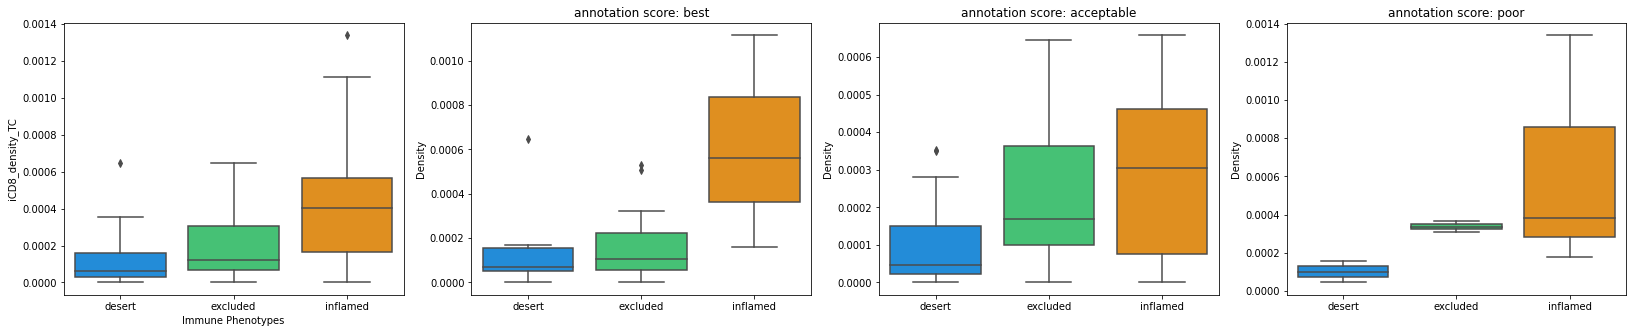

sCD8_density_TC
73
2 best
annotation_quality:  best 35
1 acceptable
annotation_quality:  acceptable 31
0 poor
annotation_quality:  poor 7


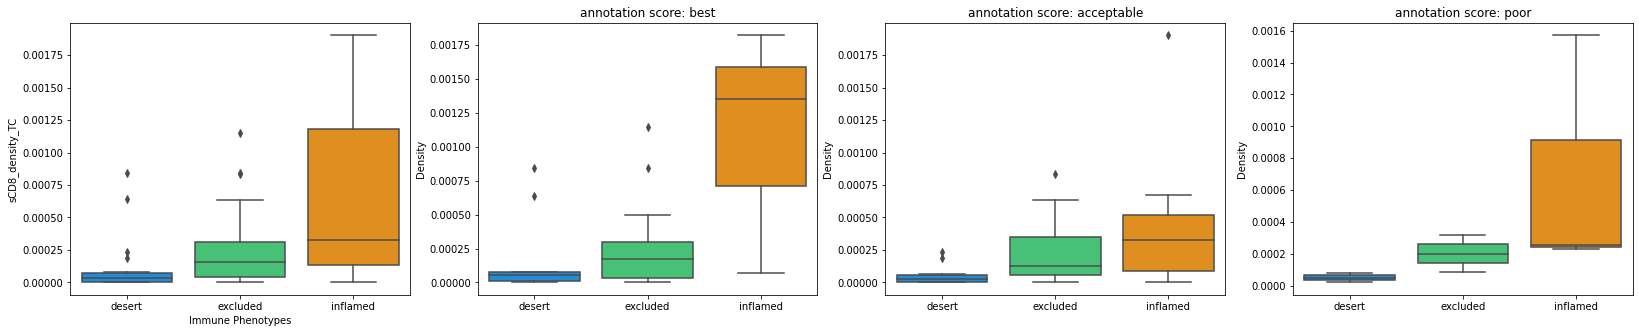

In [42]:
figs_save_directory = '/raid/sonali/project_mvs/results/final_results/immune_phenotyping'  # Replace with your desired path
os.makedirs(figs_save_directory, exist_ok=True)  # Create directory if it does not exist

custom_order = ['desert', 'excluded', 'inflamed']
custom_colors = [cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3), cm.get_cmap('jet')(0.75)] # colormaps
annotation_quality_labels = {2: 'best', 1: 'acceptable', 0: 'poor'}
plot_col_list = ['iCD8_density_TC', 'sCD8_density_TC']

for col in plot_col_list:
    print(col)
    fig, axes = plt.subplots(1, 4, figsize=(4 * 7, 5))
    sns.boxplot(x='cd8_phenotype_revised', y=col, data=df_merged, order=custom_order, palette=custom_colors, ax=axes[0])
    axes[0].set_xlabel('Immune Phenotypes')
    axes[0].set_ylabel(col)
    print(len(df_merged))

    # saving 
    fig_single, ax_single = plt.subplots(figsize=(5, 5))
    sns.boxplot(x='cd8_phenotype_revised', y=col, data=df_merged, order=custom_order, palette=custom_colors, ax=ax_single)
    ax_single.set_title('')
    ax_single.set_xlabel('')
    ax_single.set_ylabel('Density')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Use scientific notation
 
    fig_single.savefig(os.path.join(figs_save_directory, f'3class_{col}_all.svg'), bbox_inches='tight', dpi=400)
    fig_single.savefig(os.path.join(figs_save_directory, f'3class_{col}_all.png'), bbox_inches='tight', dpi=400)
    fig_single.savefig(f'3class_{col}_all.png', bbox_inches='tight', dpi=400)
    plt.close(fig_single)

    i = 1
    for key, value in annotation_quality_labels.items():
        print(key, value)
        condition = df_merged['annotation_quality'] == key
        filtered_df = df_merged[condition]
        print('annotation_quality: ', value, len(filtered_df))

        # plt.figure(figsize=(10, 6))
        sns.boxplot(x='cd8_phenotype_revised', y=col, data=filtered_df, order=custom_order, palette=custom_colors, ax=axes[i])

        axes[i].set_xlabel('')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'annotation score: {value}')  
        i+=1

        # saving 
        fig_single, ax_single = plt.subplots(figsize=(5, 5))
        sns.boxplot(x='cd8_phenotype_revised', y=col, data=filtered_df, order=custom_order, palette=custom_colors, ax=ax_single)
        ax_single.set_title('')
        ax_single.set_xlabel('')
        ax_single.set_ylabel('Density', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)

        plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Use scientific notation
 

        # plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.4f}'))

        file_path = os.path.join(figs_save_directory, f'{col}_{value}.png')
        fig_single.savefig(os.path.join(figs_save_directory, f'3class_{col}_{value}.svg'), bbox_inches='tight', dpi=400)
        fig_single.savefig(os.path.join(figs_save_directory, f'3class_{col}_{value}.png'), bbox_inches='tight', dpi=400)
        fig_single.savefig(f'3class_{col}_{value}.png', bbox_inches='tight', dpi=400)
        # plt.show()
        plt.close(fig_single)

    plt.show()


In [43]:
print(df_merged['cd8_phenotype_revised'].value_counts())
condition = df_merged['annotation_quality'] == 2

filtered_df = df_merged[condition]

print(filtered_df['cd8_phenotype_revised'].value_counts())


excluded    35
desert      24
inflamed    14
Name: cd8_phenotype_revised, dtype: int64
excluded    22
desert      10
inflamed     3
Name: cd8_phenotype_revised, dtype: int64


In [44]:
cm.get_cmap('terrain')(0.14)

<ipython-input-44-16155b691423>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm.get_cmap('terrain')(0.14)


(0.016993464052287577, 0.5660130718954248, 0.9660130718954248, 1.0)

In [45]:
cm.get_cmap('terrain')(0.14) + cm.get_cmap('terrain')(0.3)
average = tuple((x + y) / 2 for x, y in zip(cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3)))
average


<ipython-input-45-e2faf286e2b8>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm.get_cmap('terrain')(0.14) + cm.get_cmap('terrain')(0.3)
<ipython-input-45-e2faf286e2b8>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  average = tuple((x + y) / 2 for x, y in zip(cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3)))


(0.10457516339869281, 0.7022222222222223, 0.7022222222222223, 1.0)

<ipython-input-46-c571988a0708>:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_cold = tuple((x + y) / 2 for x, y in zip(cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3)))
<ipython-input-46-c571988a0708>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_dict = {'cold': color_cold, 'hot': cm.get_cmap('jet')(0.75)}


iCD8_density_TC
73
2 best
annotation_quality:  best 35
1 acceptable
annotation_quality:  acceptable 31
0 poor
annotation_quality:  poor 7


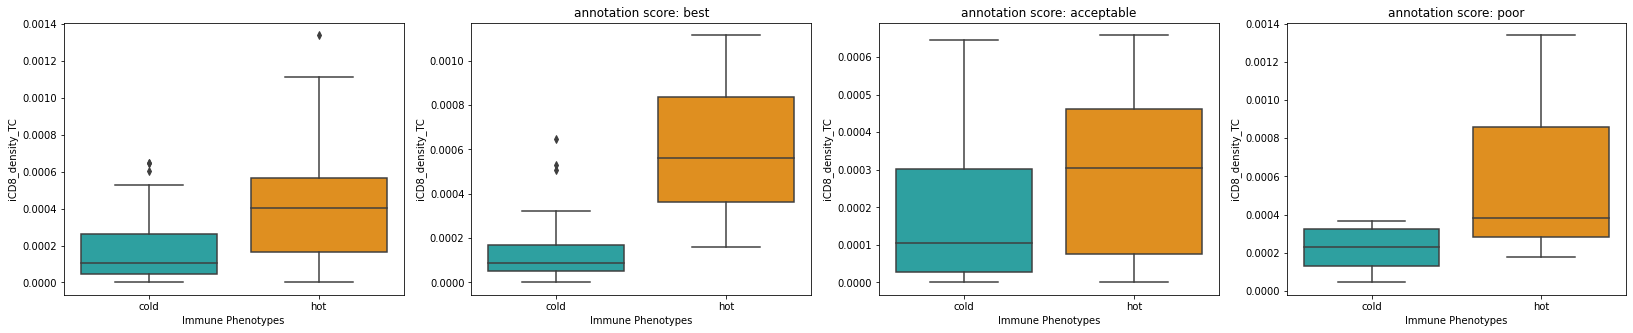

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

sCD8_density_TC
73
2 best
annotation_quality:  best 35
1 acceptable
annotation_quality:  acceptable 31
0 poor
annotation_quality:  poor 7


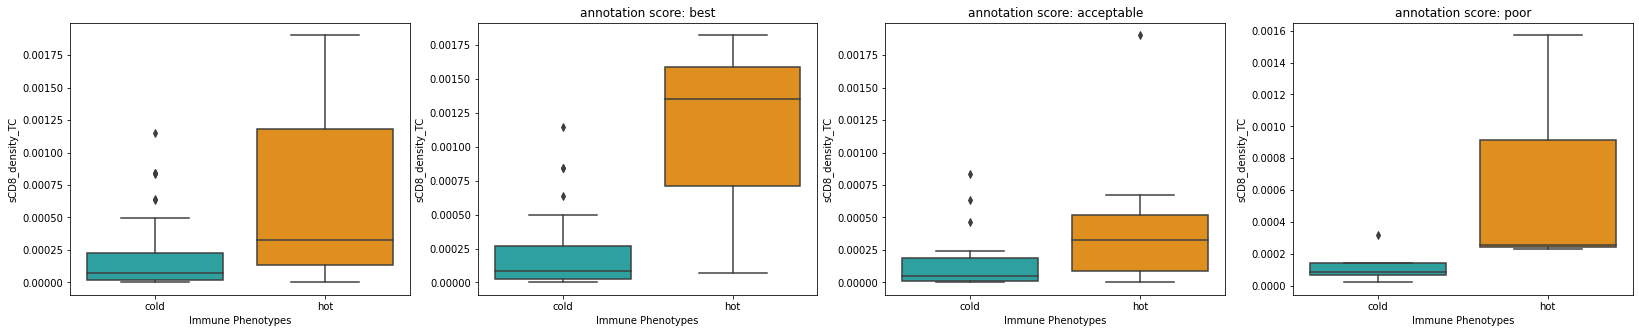

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

In [46]:
mapping_dict = {'desert': 'cold', 'excluded': 'cold', 'inflamed': 'hot'}
color_cold = tuple((x + y) / 2 for x, y in zip(cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3)))
color_dict = {'cold': color_cold, 'hot': cm.get_cmap('jet')(0.75)}

# custom_colors = [cm.get_cmap('terrain')(0.14), cm.get_cmap('terrain')(0.3), cm.get_cmap('jet')(0.75)] # colormaps

custom_order = ['cold', 'hot']
annotation_quality_labels = {2: 'best', 1: 'acceptable', 0: 'poor'}

df_merged['cd8_phenotype_revised_'] = df_merged['cd8_phenotype_revised'].map(mapping_dict)

plot_col_list = ['iCD8_density_TC', 'sCD8_density_TC']

for col in plot_col_list:
    print(col)
    fig, axes = plt.subplots(1, 4, figsize=(4 * 7, 5))
    sns.boxplot(x='cd8_phenotype_revised_', y=col, data=df_merged, order=custom_order, ax=axes[0], palette=color_dict)
    axes[0].set_xlabel('Immune Phenotypes')
    axes[0].set_ylabel(col)
    print(len(df_merged))

    # saving 
    fig_single, ax_single = plt.subplots(figsize=(5, 5))
    sns.boxplot(x='cd8_phenotype_revised_', y=col, data=df_merged, order=custom_order, ax=ax_single, palette=color_dict)
    ax_single.set_title('')
    ax_single.set_xlabel('')
    ax_single.set_ylabel('Density')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    
    plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Use scientific notation
 
    fig_single.savefig(os.path.join(figs_save_directory, f'2class_{col}_all.svg'), bbox_inches='tight', dpi=400)
    fig_single.savefig(os.path.join(figs_save_directory, f'2class_{col}_all.png'), bbox_inches='tight', dpi=400)
    plt.close(fig_single)

    i = 1
    for key, value in annotation_quality_labels.items():
        print(key, value)
        condition = df_merged['annotation_quality'] == key
        filtered_df = df_merged[condition]
        print('annotation_quality: ', value, len(filtered_df))

        plt.figure(figsize=(10, 6))
        sns.boxplot(x='cd8_phenotype_revised_', y=col, data=filtered_df, order=custom_order, ax=axes[i], palette=color_dict)

        axes[i].set_xlabel('Immune Phenotypes')
        axes[i].set_ylabel(col)
        axes[i].set_title(f'annotation score: {value}')  
        i+=1

        # saving 
        fig_single, ax_single = plt.subplots(figsize=(5, 5))
        sns.boxplot(x='cd8_phenotype_revised_', y=col, data=filtered_df, order=custom_order, ax=ax_single, palette=color_dict)
        ax_single.set_title('')
        ax_single.set_xlabel('')
        ax_single.set_ylabel('Density')
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14) 

        plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))  # Use scientific notation
 
        fig_single.savefig(os.path.join(figs_save_directory, f'2class_{col}_{value}.svg'), bbox_inches='tight', dpi=400)
        fig_single.savefig(os.path.join(figs_save_directory, f'2class_{col}_{value}.png'), bbox_inches='tight', dpi=400)
        plt.close(fig_single)

    # plt.tight_layout()
    plt.show()

#### classification and clustering: 3 vs 2 immune phenotypes

In [47]:
annotation_quality_labels = {2: 'best', 1: 'acceptable', 0: 'poor'}
df_merged['annotation_quality_'] = df_merged['annotation_quality'].map(annotation_quality_labels)
df_merged


,tupro_id,iCD8_density_TC,sCD8_density_TC,iCD8_area_TC,sCD8_area_TC,iCD8_count_TC,sCD8_count_TC,iCD8_density_IM,sCD8_density_IM,iCD8_area_IM,...,immune_type_CD8+,annotation_quality,biopsy_localisation,Comment,Exclude,total_density_TC,total_density_IM,total_density,cd8_phenotype_revised_,annotation_quality_
0,MABABAB,0.000114,0.000027,5.625919e+05,7.532283e+04,64,2,0.000000,0.000000,0.000000e+00,...,desert,2,brain,NaN,0,0.000103,NaN,0.000103,cold,best
1,MALYLEJ,0.000000,0.000000,0.000000e+00,0.000000e+00,0,0,0.000027,0.000021,2.970959e+06,...,desert,1,brain,NaN,0,NaN,0.000027,0.000027,cold,acceptable
2,MADUFEM,0.000070,0.000000,7.169347e+04,1.489664e+02,5,0,0.000000,0.000000,0.000000e+00,...,desert,2,brain,NaN,0,0.000070,NaN,0.000070,cold,best
3,MACYHYS,0.000167,0.001148,3.013941e+07,1.880769e+05,5039,216,0.000000,0.000000,0.000000e+00,...,inflamed,2,soft tissue,NaN,0,0.000173,NaN,0.000173,cold,best
4,MECADAC,0.000169,0.000034,1.319910e+07,8.887877e+04,2234,3,0.000184,0.000064,2.740439e+07,...,desert,2,soft tissue,NaN,0,0.000168,0.000125,0.000133,cold,best
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,MYBYHER,0.000108,0.000082,8.493735e+07,6.955973e+06,9212,570,0.000123,0.000117,2.917416e+07,...,excluded,2,other,NaN,0,0.000106,0.000121,0.000111,cold,best
81,MUFOFOP,0.000382,0.000254,3.553409e+07,5.867285e+06,13583,1490,0.000323,0.000079,1.112354e+07,...,inflamed,0,soft tissue,NaN,0,0.000364,0.000163,0.000276,hot,poor
82,MULELEZ,0.001340,0.001570,4.828908e+07,1.469761e+07,64701,23081,0.001183,0.001606,2.445630e+07,...,inflamed,0,soft tissue,@Sonali: Very inflamed Tumor tends to be class...,0,0.001394,0.001408,0.001400,hot,poor
83,MYJILAS,0.000064,0.000021,7.460478e+07,3.804196e+05,4796,8,0.000069,0.000015,2.986190e+07,...,desert,1,soft tissue,NaN,0,0.000064,0.000057,0.000062,cold,acceptable


In [48]:
df_merged.columns

Index(['tupro_id', 'iCD8_density_TC', 'sCD8_density_TC', 'iCD8_area_TC',
       'sCD8_area_TC', 'iCD8_count_TC', 'sCD8_count_TC', 'iCD8_density_IM',
       'sCD8_density_IM', 'iCD8_area_IM', 'sCD8_area_IM', 'iCD8_count_IM',
       'sCD8_count_IM', 'iCD3_density_TC', 'sCD3_density_TC', 'iCD3_area_TC',
       'sCD3_area_TC', 'iCD3_count_TC', 'sCD3_count_TC', 'iCD3_density_IM',
       'sCD3_density_IM', 'iCD3_area_IM', 'sCD3_area_IM', 'iCD3_count_IM',
       'sCD3_count_IM', 'data split', 'Analysis_Region',
       'Revised immune diagnosis', 'Density Tumor', 'Density Stroma total',
       'Tumor Area (um²)', 'Tumor:_AP_Positive_Cells',
       'Total_Stroma:_AP_Positive_Cells', 'Total Stromal area',
       'cd8_phenotype_revised', 'pathology_immune_diagnosis',
       'immune_type_reported', 'immune_type_CD8+', 'annotation_quality',
       'biopsy_localisation', 'Comment', 'Exclude', 'total_density_TC',
       'total_density_IM', 'total_density', 'cd8_phenotype_revised_',
       'annotation

In [65]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import statistics


condition = df_merged['annotation_quality'] == 2
filtered_df = df_merged[condition]
X = filtered_df[['Density Tumor', 'Density Stroma total']]
# X = filtered_df[['sCD8_density_TC', 'iCD8_density_TC', 'sCD8_density_IM', 'iCD8_density_IM']]
y = filtered_df['cd8_phenotype_revised_']  # cd8_phenotype_revised_

skf = StratifiedKFold(n_splits=5, random_state=21, shuffle=True) # random_state=21 for best samples only and 2 classes; for all other cases random_state=13


clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=21)
scores = cross_val_score(clf, X, y, cv=skf)
print(round(statistics.mean(scores), 3), round(statistics.stdev(scores), 3))

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=21)
scores = cross_val_score(clf, X, y, cv=skf, scoring='f1_weighted')
print(round(statistics.mean(scores), 3), round(statistics.stdev(scores), 3))


/home/sonali/miniconda3/envs/mvsenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


0.914 0.078


/home/sonali/miniconda3/envs/mvsenv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


0.891 0.105


In [ ]:
filtered_df['cd8_phenotype_revised_'].value_counts()
# 33 1028

cold    32
hot      3
Name: cd8_phenotype_revised_, dtype: int64

In [127]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, RocCurveDisplay
import matplotlib.pyplot as plt
import statistics

# Set a fixed random seed for reproducibility
np.random.seed(754)  # You can choose any integer seed value # 5346

# Sample data simulation: Replace this with your dataset
# df_merged = ... (Load your dataset)

# Map labels
df_merged['cd8_phenotype_revised__'] = df_merged['cd8_phenotype_revised_'].map({'cold': 0, 'hot': 1})

# Filtered dataset
condition = df_merged['annotation_quality'] == 2
filtered_df = df_merged[condition]

X = filtered_df[['Density Tumor', 'Density Stroma total']]
y = filtered_df['cd8_phenotype_revised__']

# Manually enforce stratified splits with at least one "hot" class per fold
def custom_stratified_splits(X, y, n_splits):
    # Create indices for each class
    hot_indices = np.where(y == 1)[0]
    cold_indices = np.where(y == 0)[0]
    
    # Shuffle indices with a fixed random seed
    np.random.shuffle(hot_indices)
    np.random.shuffle(cold_indices)
    
    # Create folds manually
    splits = []
    hot_per_fold = 1  # len(hot_indices) // n_splits

    for i in range(n_splits):
        test_hot = hot_indices[i * hot_per_fold : (i + 1) * hot_per_fold]
        test_cold = cold_indices[i::n_splits]
        test_indices = np.concatenate([test_hot, test_cold])
        train_indices = np.setdiff1d(np.arange(len(y)), test_indices)
        splits.append((train_indices, test_indices))

    return splits

# Create custom splits
n_splits = 3
splits = custom_stratified_splits(X, y, n_splits)

# Initialize classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=75684)

# Lists to store metrics
accuracy_scores = []
f1_scores = []
roc_auc_scores = []

# Perform Cross-Validation
fold_idx = 1
for train_indices, test_indices in splits:
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Predictions and probabilities
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]  # Probability for class 1 ("hot")
    
    # Metrics calculation
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test, y_prob, average='macro')
    
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    roc_auc_scores.append(auc_roc)
    
    fold_idx += 1

# Print averaged metrics over all folds
print("Accuracy: ", round(statistics.mean(accuracy_scores), 3), "±", round(statistics.stdev(accuracy_scores), 3))
print("F1 Score: ", round(statistics.mean(f1_scores), 3), "±", round(statistics.stdev(f1_scores), 3))
print("AUC-ROC: ", round(statistics.mean(roc_auc_scores), 3), "±", round(statistics.stdev(roc_auc_scores), 3))


Accuracy:  0.914 ± 0.004
F1 Score:  0.873 ± 0.006
AUC-ROC:  0.845 ± 0.047


In [87]:
# # ANOVA t-test

# import scipy.stats as stats

# # Group the data by category
# groups = [group['iCD8_density_TC'].values for name, group in df_merged.groupby('cd8_phenotype_revised')]

# # Perform one-way ANOVA
# f_value, p_value = stats.f_oneway(*groups)
# print(f"ANOVA F-value: {f_value}, p-value: {p_value}")

# h_stat, p_value = stats.kruskal(*groups)
# print(f"Kruskal-Wallis H-statistic: {h_stat}, p-value: {p_value}")

# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# tukey = pairwise_tukeyhsd(df_merged['iCD8_density_TC'], df_merged['cd8_phenotype_revised'])
# print("\nTukey's HSD for Treatment:")
# print(tukey)


In [ ]:
from sklearn.cluster import KMeans

# Define the features for clustering
# X = df_merged[['iCD8_density_TC', 'sCD8_density_TC']]
X = df_merged[['Density Tumor', 'Density Stroma total']]


# Create a KMeans model and fit it to the data
kmeans = KMeans(n_clusters=3, random_state=0)
df_merged['cluster'] = kmeans.fit_predict(X)

In [ ]:
# Define the color palette based on the unique labels
unique_labels = df_merged['Revised immune diagnosis'].unique()
palette = sns.color_palette("hsv", len(unique_labels))
color_map = {label: palette[i] for i, label in enumerate(unique_labels)}

# Plot the clusters with seaborn
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df_merged, x='Density Tumor', y='Density Stroma total', hue='Revised immune diagnosis', style='cluster', palette=color_map, s=200)
# sns.scatterplot(data=df_merged, x='iCD8_density_TC', y='sCD8_density_TC', hue='Revised immune diagnosis', style='cluster', palette=color_map, s=200)
plt.title('Clustering Visualization with Labels')
plt.xlabel('iCD8_density_TC')
plt.ylabel('sCD8_density_TC 2')
plt.legend(title='Label')
plt.show()


In [ ]:
unique_labels

In [ ]:
palette = sns.color_palette("hsv", len(unique_labels))
palette

In [ ]:
color_map